### Nam Tu - 153076622 - Pyspark and MapReduce

### Task 1.1

A bag (multiset) is a group of objects where a single object can appear multiple times, whereas it can appear only once in a set.

The operation produces the natural join between 2 relations. The first relation is comprised of 2 attributes A, B. The second relation is also comprised of 2 attributes C and D, but the second relation has been applied a condition of only taking tuples whose value in C is larger than that in attribute B of the first relation

```
QUICK IMPLEMENTATION MOCKUP

R(A,B)
S(C,D)

result = []

for (a, b) in R:
    for (c, d) in S:
        if c > b:
            result.append((a, b, c, d))


```

### Task 1.2

1. The code generates numbers from 1 to (amount of numbers per partition) * no.partitions , the entire set is then partitioned into 10 parts. The 10 parts are then passed off onto a MapReduce process which map a truth value to each count (1 if a randomly generated point lies in a circle of radius 1, 0 otherwise). The total number of points that fits the condition is then calculated via aggregation in the reduce stage. From which the value of pi can be estimated  via the formula 4*(no. of points in the circle)/no. of points generated.

2. sc.parrallelize takes the entire dataset and turns it into an RDD with the number of partitions stated (10 in this case), which will enable the ability to do parrallel computations (hence the name). The RDD can then be passed off onto a MapReduce process, making the computation much faster.

3. Technically there is no key-value pair since the function only returns a boolean, and the final mapping result is an array of 1's and 0's. If we are assessing theoretically then it follows as such:




    The key-value pairs are of the form (number, boolean). Where the number is the count of numbers that have already been passed off into f, and the boolean is 1 if the randomly generation number fits the condition of f, 0 otherwise. The f function can be seen in the implementation. 

4. Increasing the amount of data moves the results towards the true value of pi, decreasing does the opposite.

In [3]:
from random import random
from operator import add
import pyspark
sc = pyspark.SparkContext("local", "CalculatePi")
partitions = 10
n1 = 100000 * partitions
n2 = 50000 * partitions
n3 = 300000 * partitions
#function which evaluates if the random x,y point is inside the unit circle
def f(_):
 x = random() * 2 - 1
 y = random() * 2 - 1
 return 1 if x ** 2 + y ** 2 < 1 else 0
#parallelize = make a range of keys and partition keys to x partitions
#assing a value to each key with .map(f)
#and finally reduce the values by summation
rdd1 = sc.parallelize(range(1, n1 + 1), partitions)
count1 = rdd1.map(f).reduce(add)
print("Pi  (with 100.000 points) is roughly %f" % (4.0 * count1 / n1))

rdd2 = sc.parallelize(range(1, n2 + 1), partitions)
count2 = rdd2.map(f).reduce(add)
print("Pi (with 50.000 points) is roughly %f" % (4.0 * count2 / n2))

rdd3 = sc.parallelize(range(1, n3 + 1), partitions)
count3 = rdd3.map(f).reduce(add)
print("Pi (with 300.000 points) is roughly %f" % (4.0 * count3 / n3))
sc.stop()

Pi  (with 100.000 points) is roughly 3.133760
Pi (with 50.000 points) is roughly 3.127840
Pi (with 300.000 points) is roughly 3.142160


### Task 1.3

The text file is fed into the instance of Spark, essentially making the textfile a RDD consisting of strings, Pyspark will do the paritition itself(?). The RDD is fed through 2 mapping functions before reducing. First, each line is formatted: punctuations and tabs removed. Each line is then split into words. Second, for each partition, we count the amount of time each word appears.

Finally, for the reduction stage, merge the count of words from each partition by adding them together. The output is the product after the MapReduce, displaying the words and their count.

In [1]:
import pyspark
sc = pyspark.SparkContext("local", "words")
lines = sc.textFile("mobydick.txt")
words = lines.map(lambda line:
line.replace(".","").replace(",","").replace("?","").replace("\t","").replace(":","")
.replace("!","").replace("-","").lower()).flatMap(lambda line: line.split(" "))
keyvalue = words.map(lambda word: (word, 1))
counts = keyvalue.reduceByKey(lambda a, b: a + b)
#retrieve at most 200 key value pairs from the rdd (it’s not wise to try to get everything)
for x in counts.take(10):
 print(x)
sc.stop()

('the', 14512)
('project', 87)
('gutenberg', 26)
('ebook', 12)
('of', 6707)
('moby', 81)
('dick;', 10)
('or', 787)
('whale', 846)
('', 4316)


### Task 1.4

Perform the same instructions in the previous task, now with 2 different RDDs made from 2 text files. We then take the top 10 words from each MapReduce job, put them into a set so that we can obtain only unique words. Each MapReduce is then converted back into normal python code where we can create a dataframe consisting of words from the set, and their corresponding counts in each of the text file. If we do not do .collect() then the data remains in the RDD form (which gives an error if we try to create a dataframe out of). Finally, plot the two counts against each other in a bar graph.

In [3]:
import pyspark
import re
import matplotlib.pyplot as plt
import pandas as pd

sc = pyspark.SparkContext("local", "words2")

lines1 = sc.textFile("frankenstein.txt") 
lines2 = sc.textFile("mobydick.txt")

words1 = (
    lines1
    .map(lambda line: re.sub(r"[^a-zA-Z\s]", "", line)) # remove trash + numbers
    .map(lambda line: line.lower())
    .flatMap(lambda line: line.split())
    .filter(lambda word: word != "")    # remove empty words
)

words2 = (
    lines2
    .map(lambda line: re.sub(r"[^a-zA-Z\s]", "", line)) # remove trash + numbers
    .map(lambda line: line.lower())
    .flatMap(lambda line: line.split())
    .filter(lambda word: word != "")    # remove empty words
)

keyvalue1 = words1.map(lambda word: (word, 1))
counts1 = keyvalue1.reduceByKey(lambda a, b: a + b)

keyvalue2 = words2.map(lambda word: (word, 1))
counts2 = keyvalue2.reduceByKey(lambda a, b: a + b)


#take top 10 from each
top10_1 = counts1.takeOrdered(10, key=lambda x: -x[1])
top10_2 = counts2.takeOrdered(10, key=lambda x: -x[1])

#merge into a set -> duplicates only appear once
unique_words = set([w for w, _ in top10_1] + [w for w, _ in top10_2])

In [4]:

print("Top 10 Frankenstein:", top10_1)
print("Top 10 Moby Dick:", top10_2)
print("Unique words:", unique_words)


Top 10 Frankenstein: [('the', 4380), ('and', 3037), ('i', 2842), ('of', 2761), ('to', 2174), ('my', 1773), ('a', 1442), ('in', 1187), ('that', 1029), ('was', 1023)]
Top 10 Moby Dick: [('the', 14614), ('of', 6715), ('and', 6446), ('a', 4697), ('to', 4661), ('in', 4215), ('that', 2955), ('his', 2522), ('it', 2383), ('i', 1943)]
Unique words: {'that', 'it', 'his', 'my', 'in', 'was', 'of', 'a', 'to', 'and', 'the', 'i'}


In [5]:
#creating dataframes
dict1 = dict(counts1.collect())
dict2 = dict(counts2.collect()) # converting count into normal python data so we can convert into dataframe

data = []
for w in unique_words:
    data.append({
        "word": w,
        "Frankenstein": dict1.get(w, 0),
        "MobyDick": dict2.get(w, 0)
    })

df = pd.DataFrame(data).sort_values("word")

print(df)

    word  Frankenstein  MobyDick
7      a          1442      4697
9    and          3037      6446
2    his           533      2522
11     i          2842      1943
4     in          1187      4215
1     it           561      2383
3     my          1773       586
6     of          2761      6715
0   that          1029      2955
10   the          4380     14614
8     to          2174      4661
5    was          1023      1638


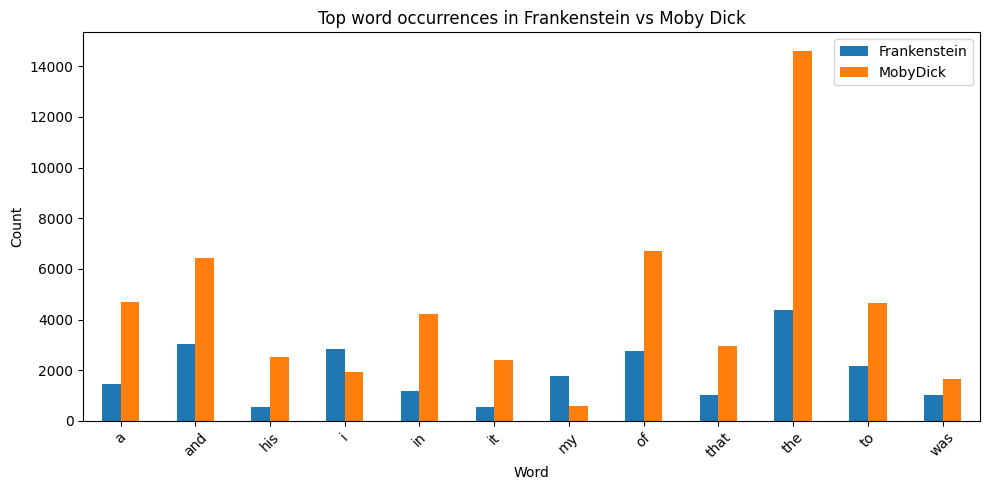

In [6]:

df.set_index("word").plot(kind="bar", figsize=(10, 5))

plt.title("Top word occurrences in Frankenstein vs Moby Dick")
plt.ylabel("Count")
plt.xlabel("Word")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sc.stop()
